# Simple Linear Regression Model
# Independent Variable i.e. Yrs of Exp
# Dependednt Variable i.e. Salary
# Predict the Salary based on Exp data feeded.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
salaryDf = pd.read_csv('salary.csv')
salaryDf.head(5)

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


<Axes: >

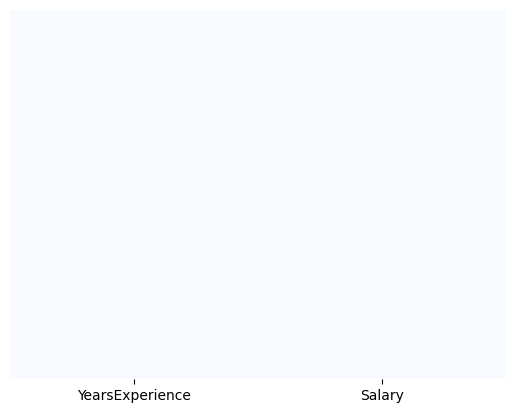

In [3]:
# EDA:
# Lets check if your df has null values or not?

sb.heatmap(salaryDf.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [4]:
# min & max sal
salaryDf[salaryDf['Salary'] == salaryDf['Salary'].max()]

,YearsExperience,Salary
34,13.5,139465


In [5]:
salaryDf[salaryDf['Salary'] == salaryDf['Salary'].min()]

,YearsExperience,Salary
2,1.5,37731


array([[<Axes: title={'center': 'YearsExperience'}>,
        <Axes: title={'center': 'Salary'}>]], dtype=object)

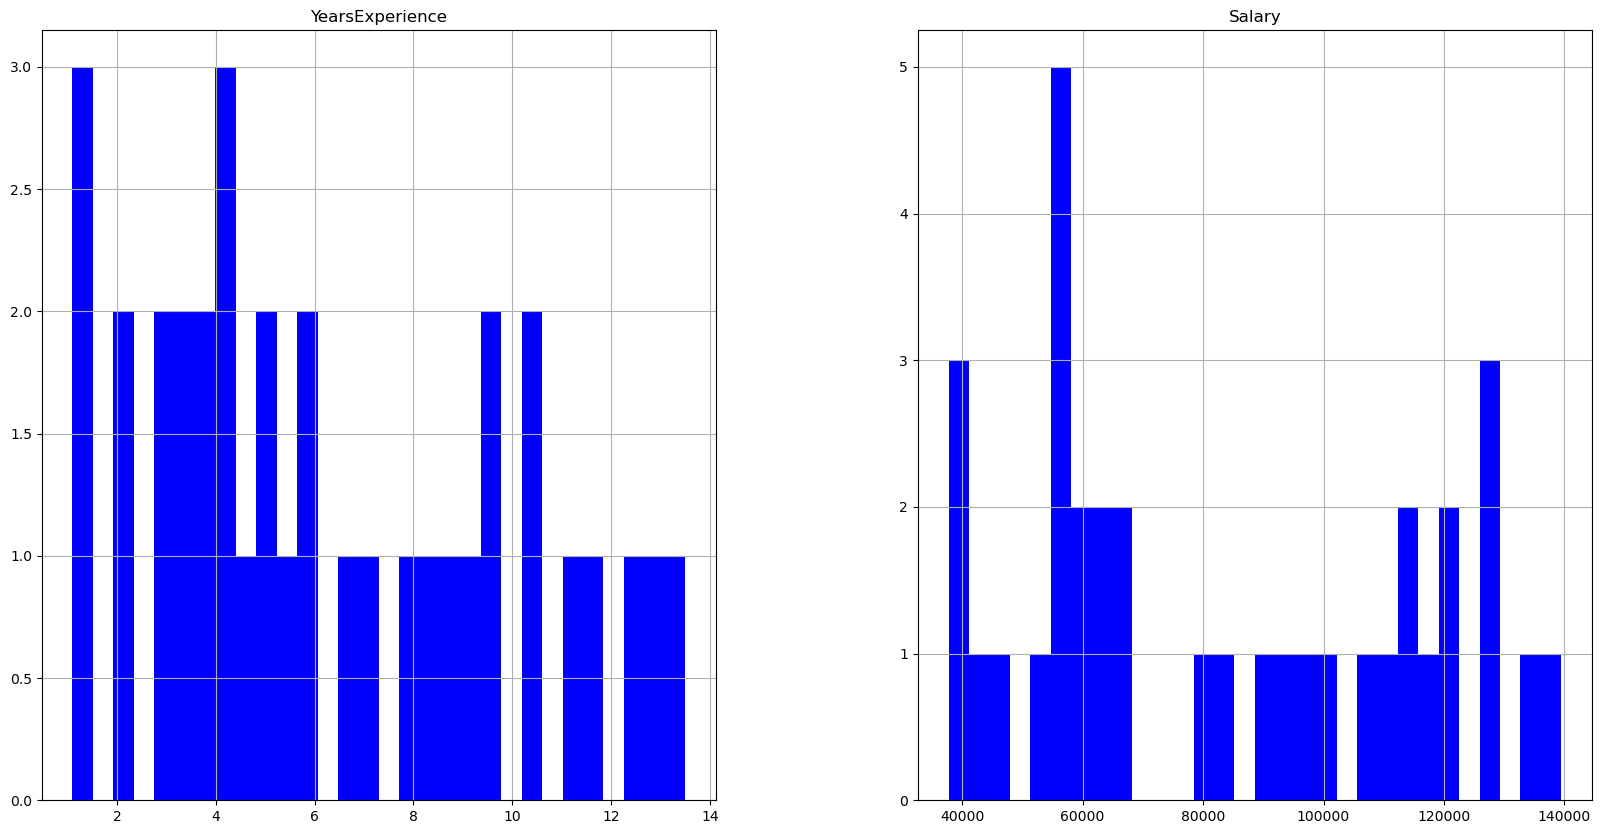

In [6]:
salaryDf.hist(bins = 30, figsize=(20,10), color='b')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


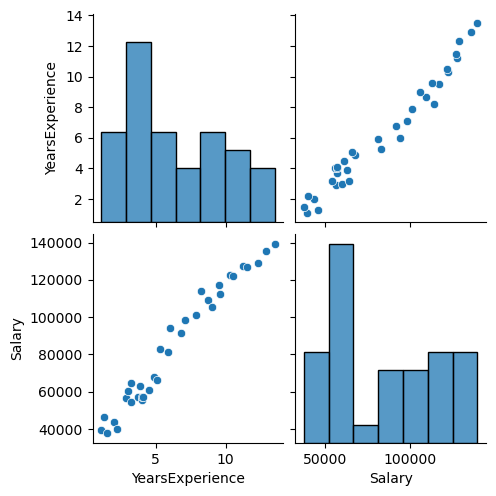

In [7]:
sb.pairplot(salaryDf)

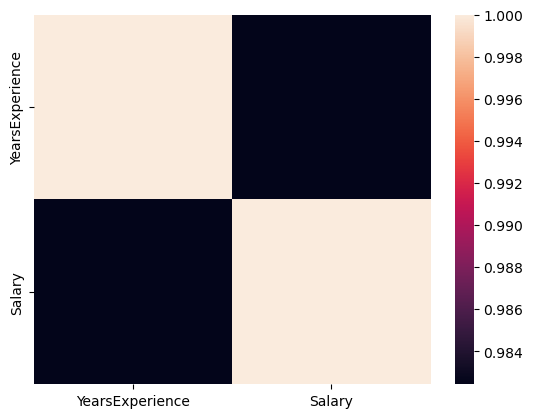

In [8]:
sb.heatmap(salaryDf.corr())
plt.show()

<Axes: xlabel='YearsExperience', ylabel='Salary'>

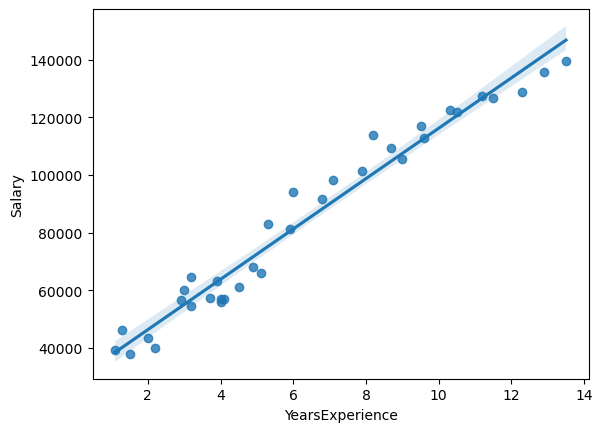

In [9]:
# regplot to obtain a straigt line between salary & yr of exp
sb.regplot(x = 'YearsExperience', y = 'Salary', data = salaryDf)

In [10]:
# Training & Testing Datasets.
salaryDf.head()

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


In [11]:
X = salaryDf[['YearsExperience']]
y = salaryDf[['Salary']]

In [12]:
X.shape

(35, 1)

In [13]:
y.shape

(35, 1)

In [14]:
X = np.array(X).astype('float32')

In [15]:
y = np.array(y).astype('float32')

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [18]:
# Train a linear Regression Model:
from sklearn.linear_model import LinearRegression

In [19]:
regML = LinearRegression(fit_intercept=True)
regML.fit(X_train, y_train)

LinearRegression()

In [20]:
regML.score(X_test, y_test)

0.9413032996206946

In [21]:
pred = regML.predict(X_test)
pred

array([[137088.9  ],
       [ 74442.17 ],
       [129929.28 ],
       [112925.17 ],
       [ 38644.035],
       [104870.586],
       [ 90551.33 ]], dtype=float32)

Text(0.5, 1.0, 'Sal Vs Yrs of Exp')

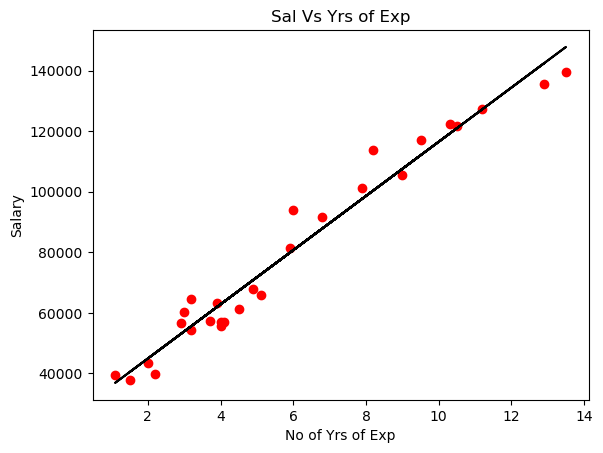

In [22]:
plt.scatter(X_train, y_train, color='red')
plt.plot(X_train, regML.predict(X_train), color='black')
plt.ylabel('Salary')
plt.xlabel('No of Yrs of Exp')
plt.title('Sal Vs Yrs of Exp')

In [23]:
no_exp = [[11]]
salaryPred = regML.predict(no_exp)
salaryPred

array([[125454.51660156]])

# Train a Linear Learner Model using SageMaker:

In [24]:
import sagemaker
import boto3
# boto3: it is a python sdk.
# It allows developers to write the code on your aws services

In [25]:
from sagemaker import Session
sgsess = sagemaker.Session()
bkt = Session().default_bucket()

In [26]:
bkt = 'arifbkt-sep23'
prefix = 'linear_learner'
rl = sagemaker.get_execution_role()
key = 'linear_trained_data'

In [27]:
X_train.shape

(28, 1)

In [28]:
#y_train = y_train[:,0]
y_train.shape

(28,)

In [29]:
print(dir(sagemaker.amazon.amazon_estimator))

['AmazonAlgorithmEstimatorBase', 'Dict', 'EstimatorBase', 'FileSystemInput', 'FileSystemRecordSet', 'Optional', 'PipelineVariable', 'RecordSet', 'TrainingInput', 'Union', '_TrainingJob', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_build_shards', 'absolute_import', 'check_and_get_run_experiment_config', 'get_image_uri', 'hp', 'image_uris', 'is_pipeline_variable', 'json', 'logger', 'logging', 'renamed_warning', 'runnable_by_pipeline', 's3_utils', 'sagemaker_timestamp', 'tempfile', 'upload_numpy_to_s3_shards', 'urlparse', 'validation', 'write_numpy_to_dense_tensor']


In [30]:
import io,os
import sagemaker.amazon.common as smac

In [31]:
buf = io.BytesIO() # Convert Numpy array format to RecordIO format # everytime it gets incremented
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0)

0

In [32]:
boto3.resource('s3').Bucket(bkt).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

In [33]:
s3_train_data = 's3://{}/{}/train/{}'.format(bkt, prefix, key)
s3_train_data

's3://arifbkt-sep23/linear_learner/train/linear_trained_data'

In [34]:
y_test.shape

(7, 1)

In [36]:
#y_test = y_test[:,0]
y_test.shape

(7,)

In [37]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0)

0

In [38]:
key = 'linear-test-data'

In [39]:
boto3.resource('s3').Bucket(bkt).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)

In [40]:
s3_test_data = 's3://{}/{}/test/{}'.format(bkt, prefix, key)
s3_test_data

's3://arifbkt-sep23/linear_learner/test/linear-test-data'

In [41]:
s3_op_loc = 's3://{}/{}/output'.format(bkt, prefix)
s3_op_loc

's3://arifbkt-sep23/linear_learner/output'

In [42]:
# training container of sagemaker built-in algo
# Ref linear-learner container image
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [46]:
# pass the container, type of instance we will use for training
linear = sagemaker.estimator.Estimator(
                            container,
                            rl,
                            train_instance_count = 1,
                            train_instance_type = 'ml.c4.xlarge',
                            output_path = s3_op_loc,
                            sagemaker_session=sagemaker.Session()
                            )

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [47]:
linear.set_hyperparameters(feature_dim = 1,
                          predictor_type = 'regressor',
                          epochs = 50,
                          num_models=32,
                          loss = 'absolute_loss',
                          mini_batch_size=5)

In [49]:
linear.fit({"train": s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-09-11-09-21-46-703


2023-09-11 09:21:46 Starting - Starting the training job...
2023-09-11 09:22:13 Starting - Preparing the instances for training.........
2023-09-11 09:23:22 Downloading - Downloading input data...
2023-09-11 09:23:52 Training - Downloading the training image......
2023-09-11 09:25:07 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/11/2023 09:25:17 INFO 140614453217088] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

In [50]:
# Deploy the model:
linear_regressor = linear.deploy(initial_instance_count=1,
                                instance_type='ml.c4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-09-11-09-55-32-133
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-09-11-09-55-32-133
INFO:sagemaker:Creating endpoint with name linear-learner-2023-09-11-09-55-32-133


-------!

In [52]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_regressor.content_type = 'text/csv'
linear_regressor.serializer = CSVSerializer()
linear_regressor.deserializer = JSONDeserializer()

In [54]:
result = linear_regressor.predict(X_test)
result

{'predictions': [{'score': 137845.828125},
  {'score': 69701.203125},
  {'score': 130057.859375},
  {'score': 111561.46875},
  {'score': 30761.41015625},
  {'score': 102800.015625},
  {'score': 87224.09375}]}

In [57]:
predictions = np.array([i['score'] for i in result['predictions']])
predictions

array([137845.828125  ,  69701.203125  , 130057.859375  , 111561.46875   ,
        30761.41015625, 102800.015625  ,  87224.09375   ])

Text(0.5, 1.0, 'Sal Vs Yrs of Exp')

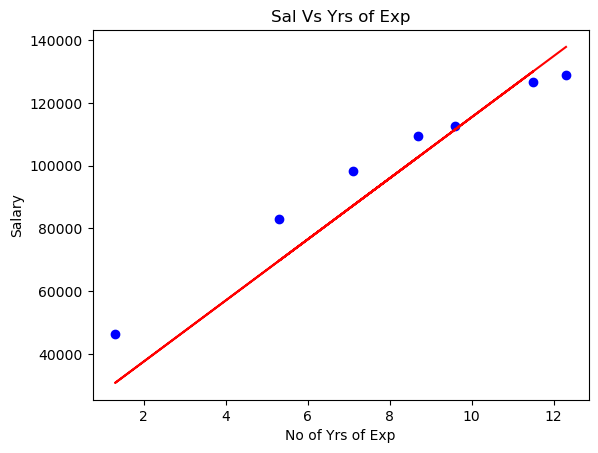

In [59]:
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, predictions, color='red')
plt.ylabel('Salary')
plt.xlabel('No of Yrs of Exp')
plt.title('Sal Vs Yrs of Exp')